In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data

Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [32]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

Using Cached


In [17]:
LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

Is first utterance?

### Classify Dialogue Acts

In [34]:
from collections import OrderedDict
from cycler import cycler

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve, confusion_matrix

from chatty.utils import dd_encodings

ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

X = np.concatenate((train_vecs,
                    train['first_utterance'].values.reshape(-1, 1),
                    train['subjectivity'].values.reshape(-1, 1),
                    train['utter_len'].values.reshape(-1, 1),
                    train['has_question_mark'].values.reshape(-1, 1)), axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [99]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
from sklearn.metrics import confusion_matrix

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.svm import SVC

In [199]:
def plot_prec_rec_results(results, save_name=None, title='', columns=[]):
    colors = ['blue', 'green', 'orange', 'red']
    for result in results:
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        ax.set_prop_cycle(cycler('color', colors))
        for cls, curves in result:
            precision = curves['precision']
            recall = curves['recall']
            ax.plot(recall, precision, label=cls)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)

    # take care of repeating legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys());
    plt.ylim((-0.05, 1.05))
    plt.xlim((-0.05, 1.05))
    if save_name:
        plt.savefig(save_name)

In [200]:
def cv_stratified_shuffle(X: np.array, y: np.array, model, splits=5):
    y_true = []
    y_proba = []
    models = []
    sss = StratifiedShuffleSplit(n_splits=splits)
    for train_index, val_index in sss.split(X, y):
        print('Training')
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(x_train, y_train)
        proba = model.predict_proba(x_val)
        y_true.append(y_val)
        y_proba.append(proba)
        models.append(model)
    classes = model.classes_
    return {
        'y_true': y_true,
        'y_proba': y_proba,
        'models': models,
        'classes': classes
    }

In [283]:
results = cv_stratified_shuffle(X, y,
                                RandomForestClassifier(),
                                splits=5)

Training
Training
Training
Training
Training


In [294]:
def plot_prec_rec(results, title='', save_name=None, figsize=(5, 5)):
    classes = results['classes']
    fig = plt.figure(1, figsize=figsize)
    ax = fig.add_subplot(111)

    # plot each split
    for y_true, y_proba in zip(results['y_true'], results['y_proba']):
        y_true_cat = pd.get_dummies(y_true)
        # reset colors so classes share the same color
        ax.set_prop_cycle(None)
        for i, cls in enumerate(classes):
            precision, recall, thresholds = \
                precision_recall_curve(y_true_cat.values[:, i],
                                       y_proba[:, i])
            ax.plot(recall, precision, label=cls)

    # show legends matching colors to splits
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys());

    # plot mean precision and recalls in black
    for i, cls in enumerate(classes):
        y_true = np.concatenate(results['y_true'])
        y_true_cat = pd.get_dummies(y_true)
        y_proba = np.concatenate(results['y_proba'])
        precision, recall, thresholds = \
            precision_recall_curve(y_true_cat.values[:, i],
                                   y_proba[:, i])
        ax.plot(recall, precision, label=cls, color='black')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    if save_name:
        plt.savefig(save_name)

    # take care of repeating legend labels



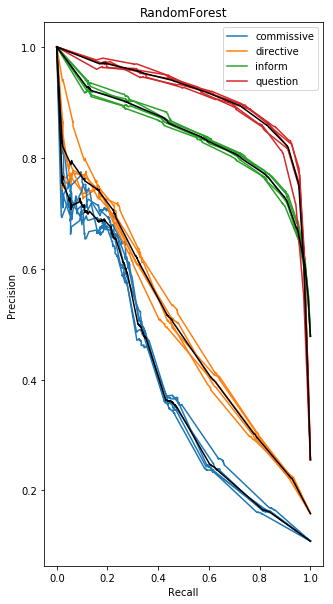

In [293]:
plot_prec_rec(results, 'RandomForest')